## Check GPU Status

In [1]:
!nvidia-smi

Mon Dec 16 08:54:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [ ]:
!pip install roboflow

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets
import os
# from google.colab import userdata
from roboflow import Roboflow

from roboflow import Roboflow

rf = Roboflow(api_key=os.environ.get("ROBOFLOW_API_KEY"))
project = rf.workspace(os.environ.get("WORKSPACE")).project(os.environ.get("PROJECT_NAME"))
version = project.version(1)
dataset = version.download("yolov11")

## Custom Training

In [5]:
%cd {HOME}

!yolo task=detect \
      mode=train \
      model=yolo11s.pt \
      data={dataset.location}/data.yaml \
      epochs=100 \
      imgsz=640 \
      plots=True \
      batch=8 \
      device=0 \
      lr0=0.01 \
      lrf=0.01

/content
100% 18.4M/18.4M [00:00<00:00, 163MB/s]
New https://pypi.org/project/ultralytics/8.3.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/football-position-detection-1/data.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [6]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	 train_batch2432.jpg
confusion_matrix_normalized.png			    R_curve.png		 train_batch2.jpg
confusion_matrix.png				    results.csv		 val_batch0_labels.jpg
events.out.tfevents.1734339364.d80f645a9549.1277.0  results.png		 val_batch0_pred.jpg
F1_curve.png					    train_batch0.jpg	 val_batch1_labels.jpg
labels_correlogram.jpg				    train_batch1.jpg	 val_batch1_pred.jpg
labels.jpg					    train_batch2430.jpg  weights
P_curve.png					    train_batch2431.jpg


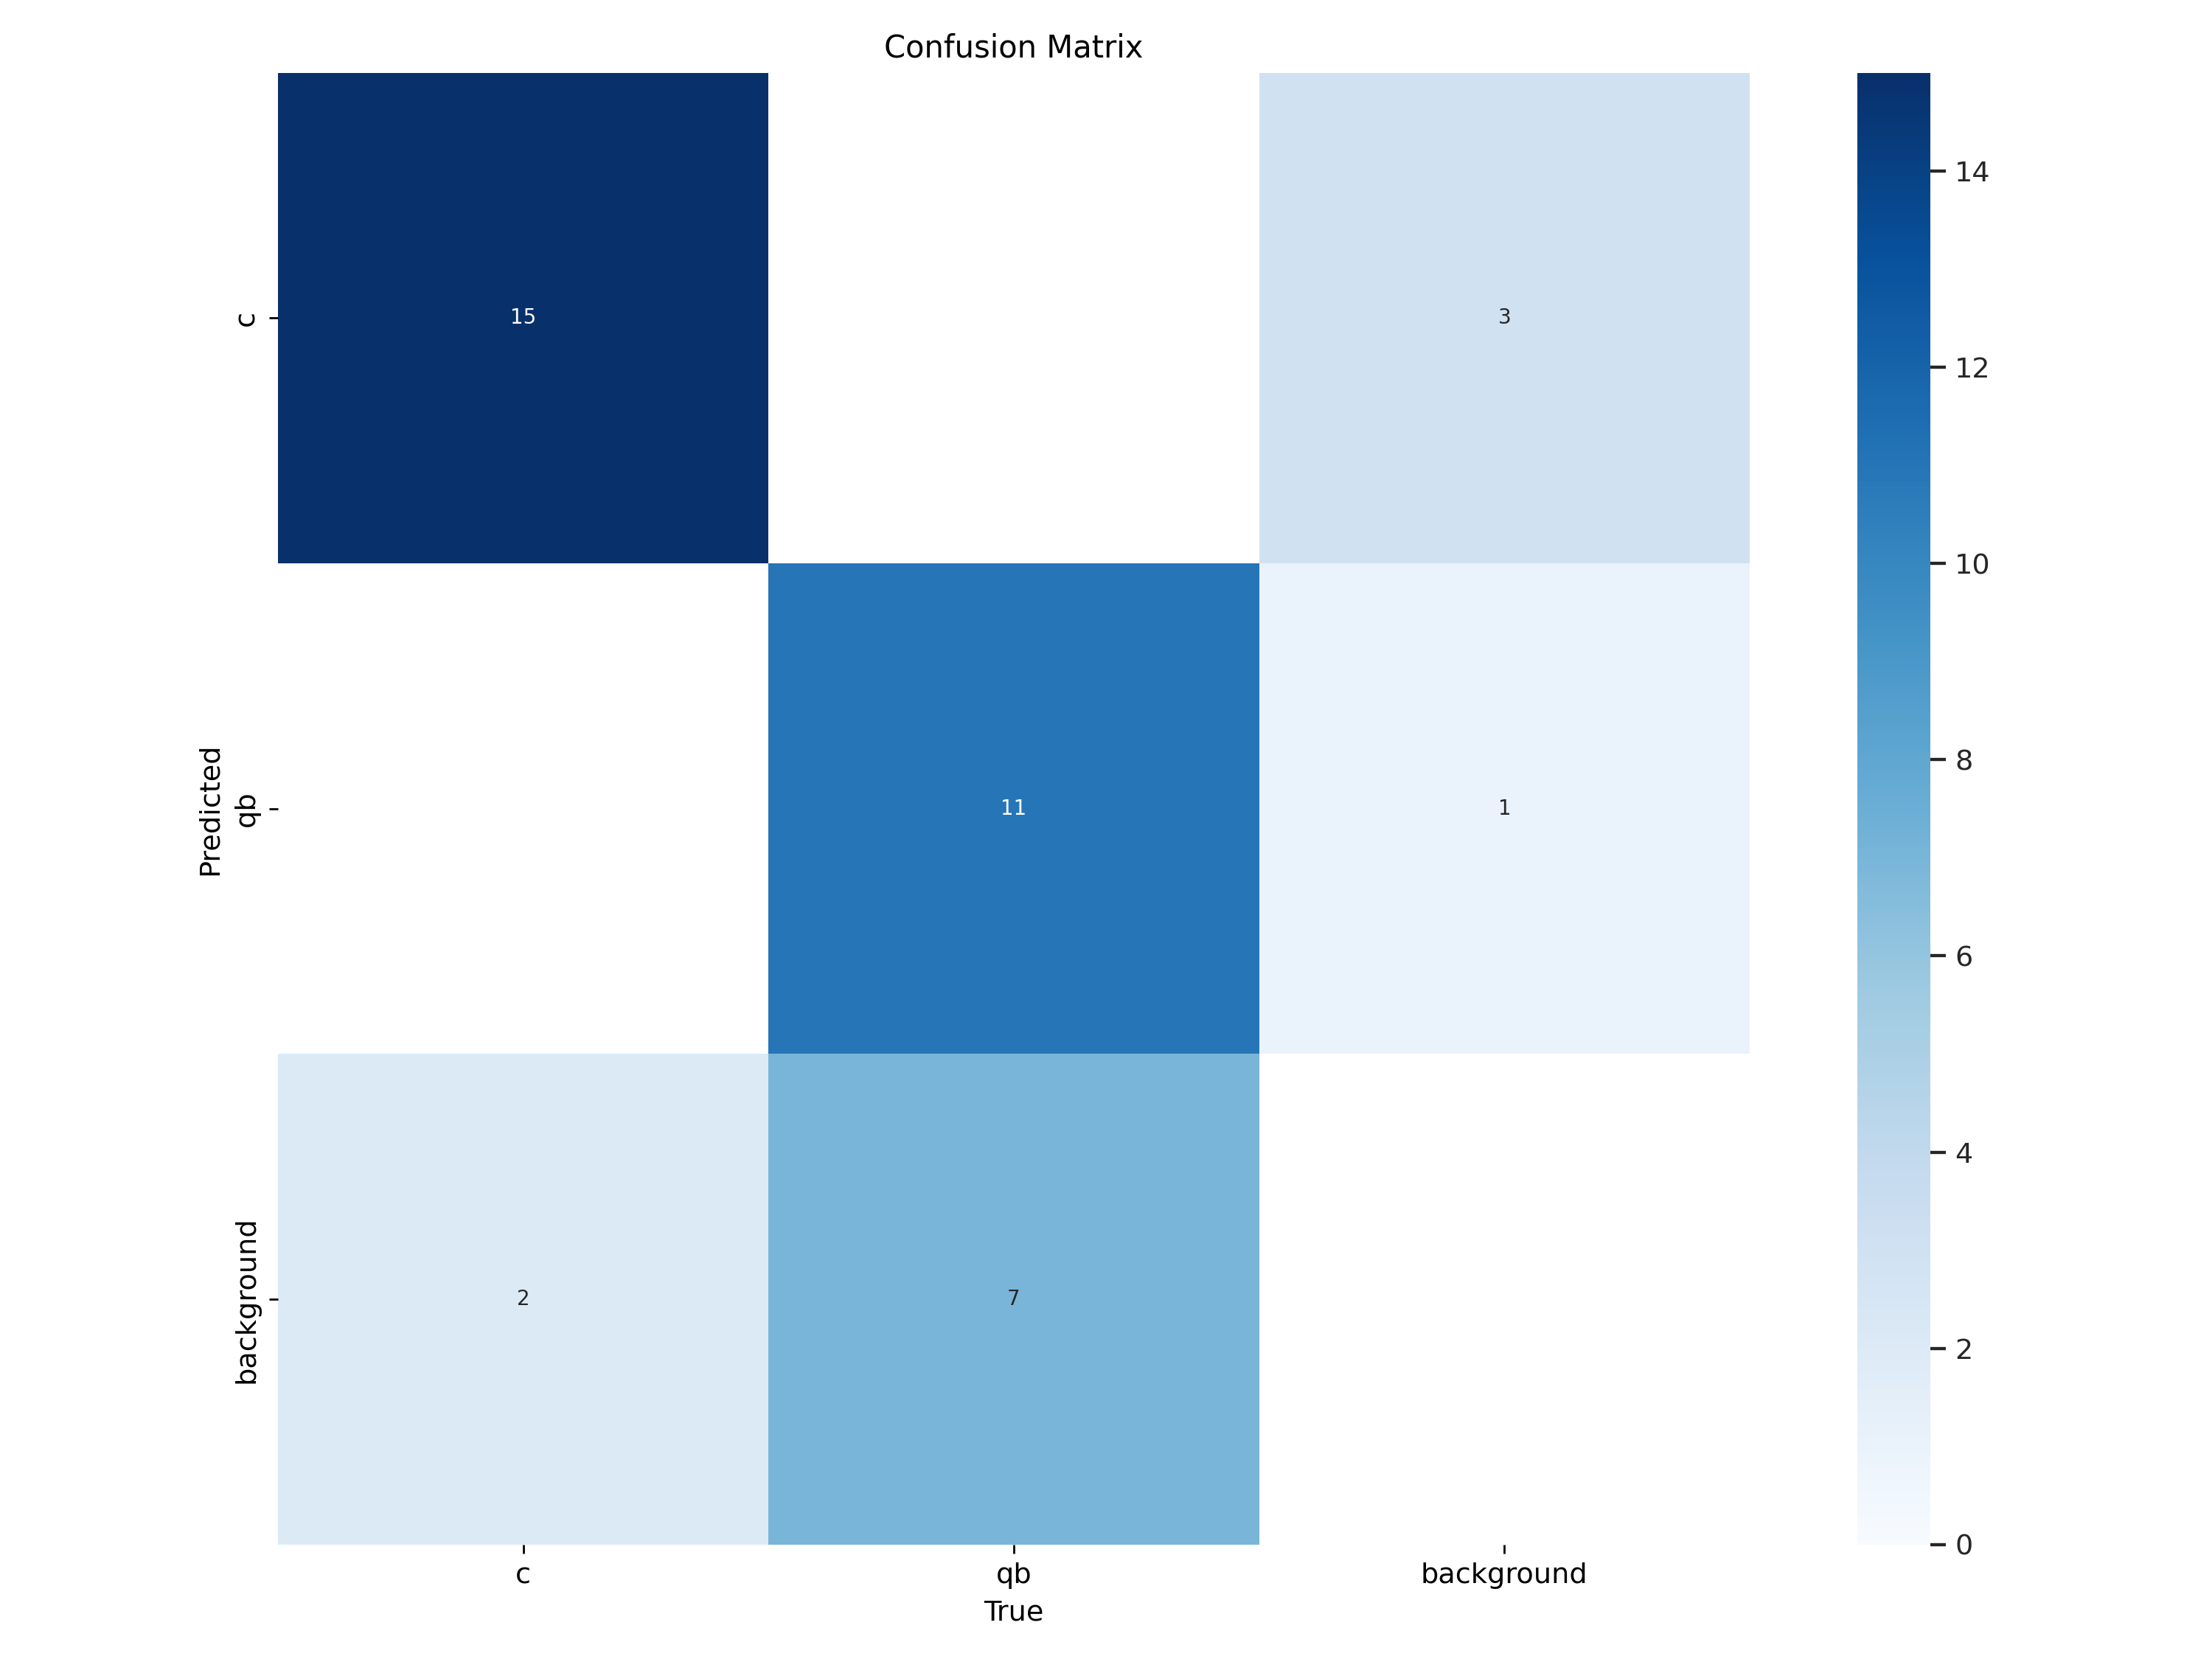

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

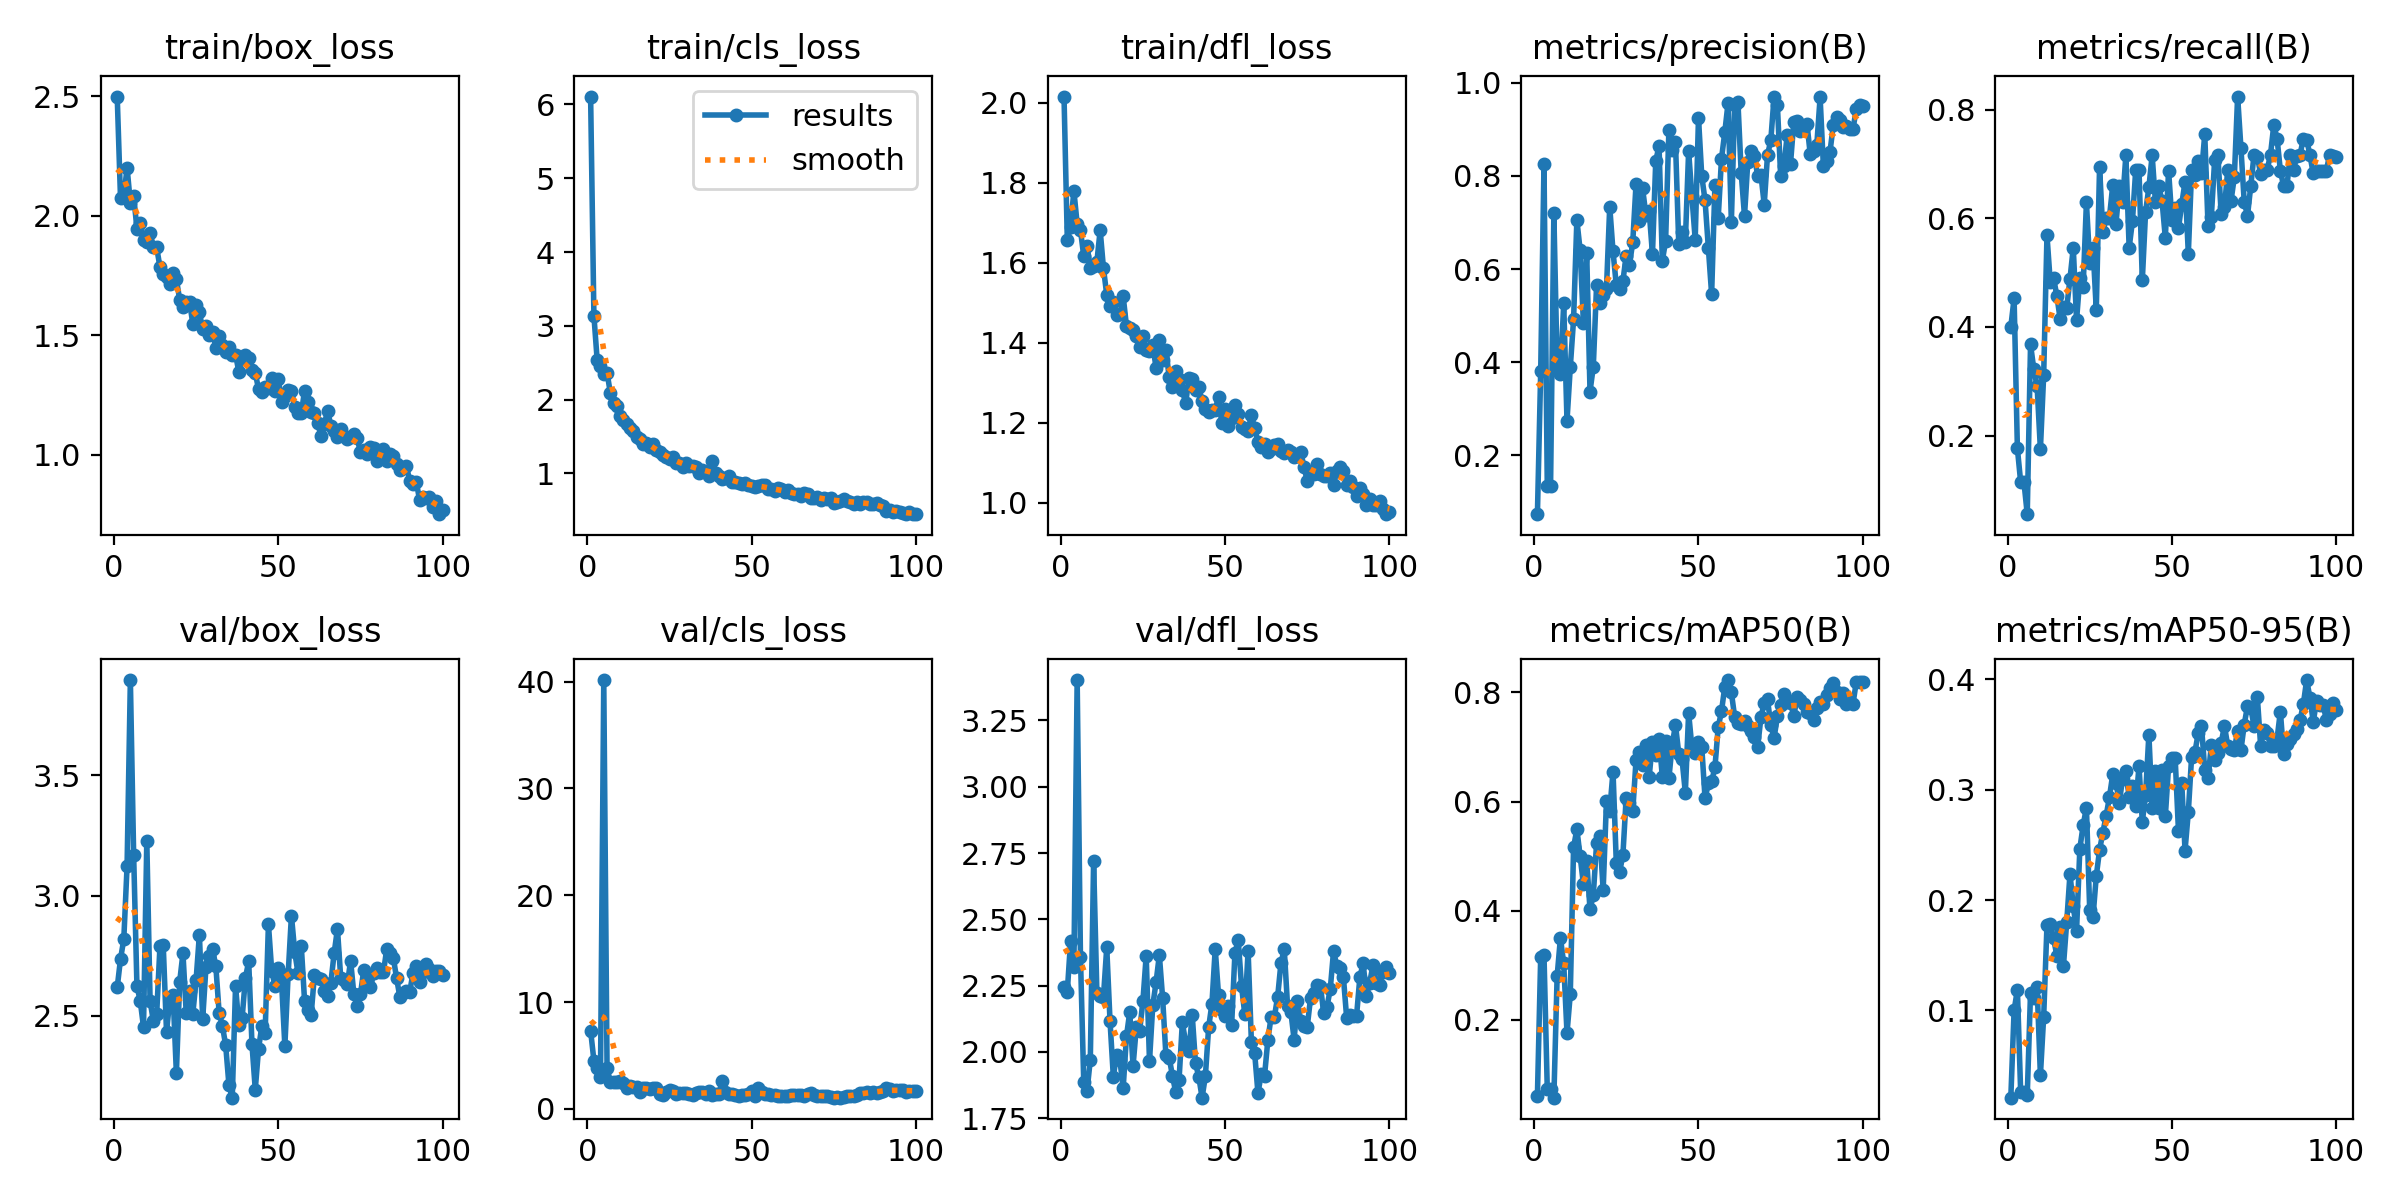

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

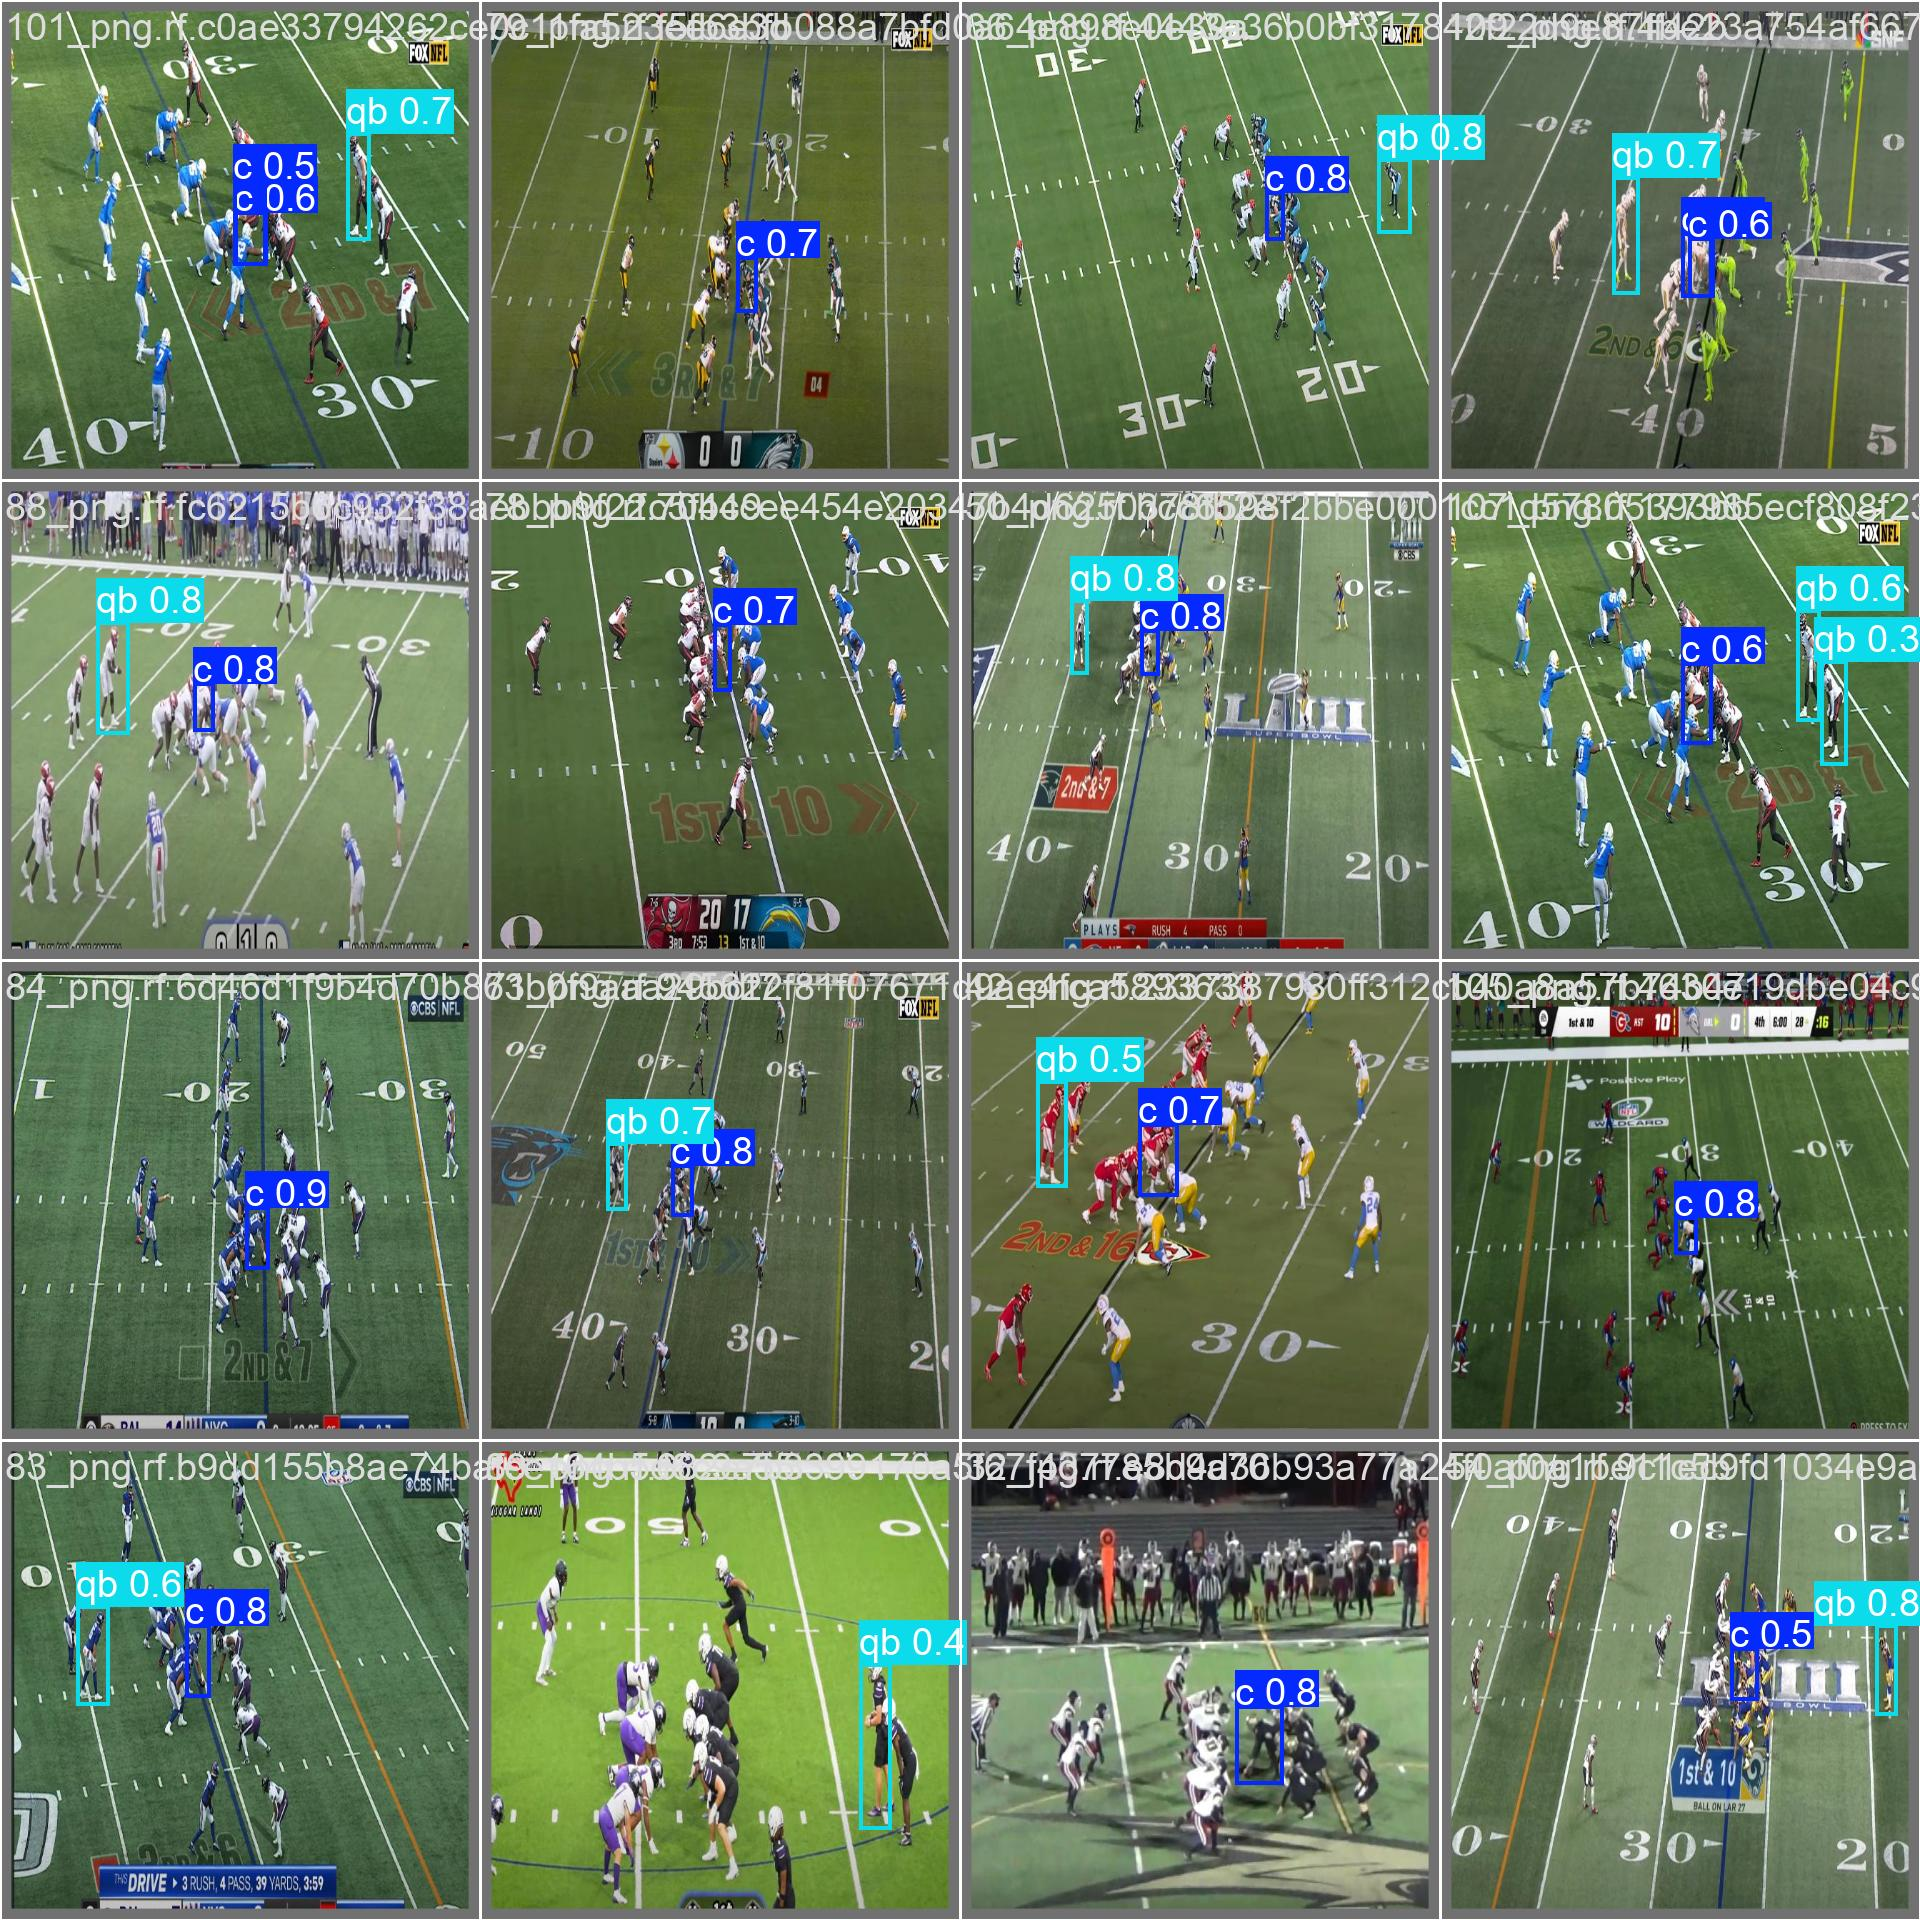

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [10]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/football-position-detection-1/valid/labels.cache... 17 images, 0 backgrounds, 0 corrupt: 100% 17/17 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:01<00:00,  1.37it/s]
                   all         17         35      0.924      0.742       0.82      0.393
                     c         17         17      0.849      0.882        0.9      0.396
                    qb         17         18          1      0.601      0.739       0.39
Speed: 0.3ms preprocess, 24.5ms inference, 0.0ms loss, 48.2ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [11]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/17 /content/datasets/football-position-detection-1/test/images/11_jpg.rf.eeab06cfb0de1e2d82321cec1bc3fa8d.jpg: 640x640 1 c, 1 qb, 15.6ms
image 2/17 /content/datasets/football-position-detection-1/test/images/13_jpg.rf.b51ea6c0ee6f5eaf3b8fff0c11bd5823.jpg: 640x640 1 c, 1 qb, 15.6ms
image 3/17 /content/datasets/football-position-detection-1/test/images/18_png.rf.c9dfbb303e756bf97deafac81974f2d7.jpg: 640x640 (no detections), 15.6ms
image 4/17 /content/datasets/football-position-detection-1/test/images/20_jpg.rf.2c8ce4d3242b58bbde5a8e0ea0d21ca2.jpg: 640x640 1 c, 1 qb, 15.5ms
image 5/17 /content/datasets/football-position-detection-1/test/images/25_jpg.rf.6f717ad47df8094ac32b21d99c57a44e.jpg: 640x640 1 c, 15.5ms
image 6/17 /content/datasets/football-position-detection-1/test/images/27_jpg.rf.1c570b276546fc74d5bd81546ad

**NOTE:** Let's take a look at few results.

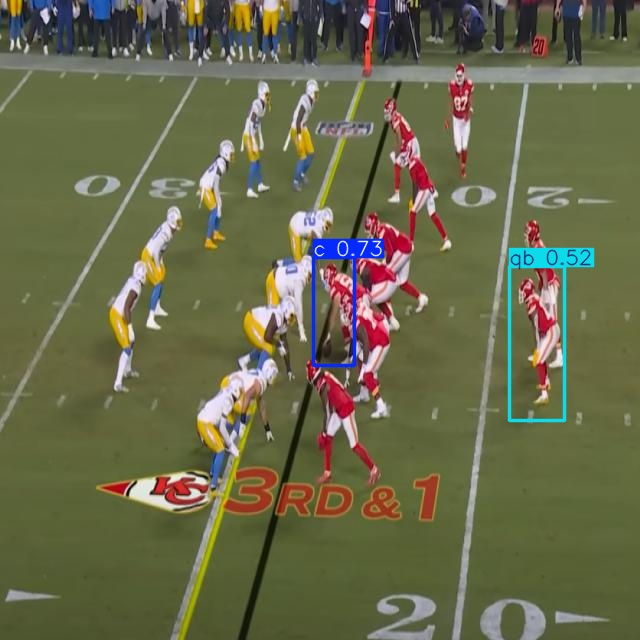

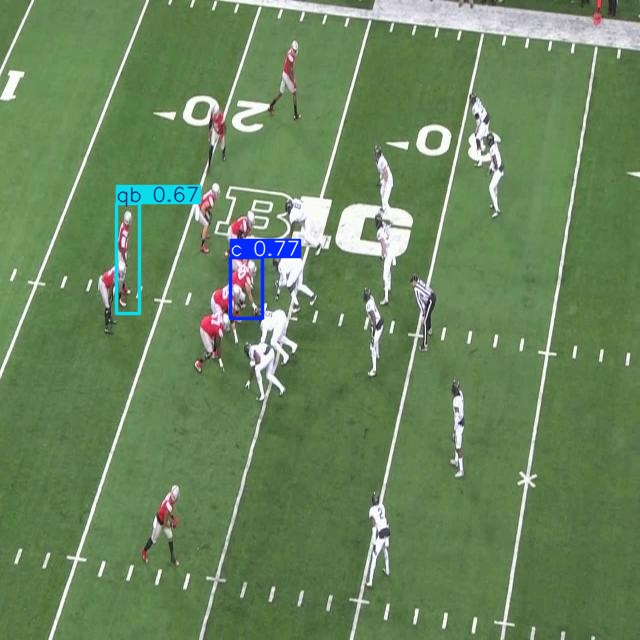

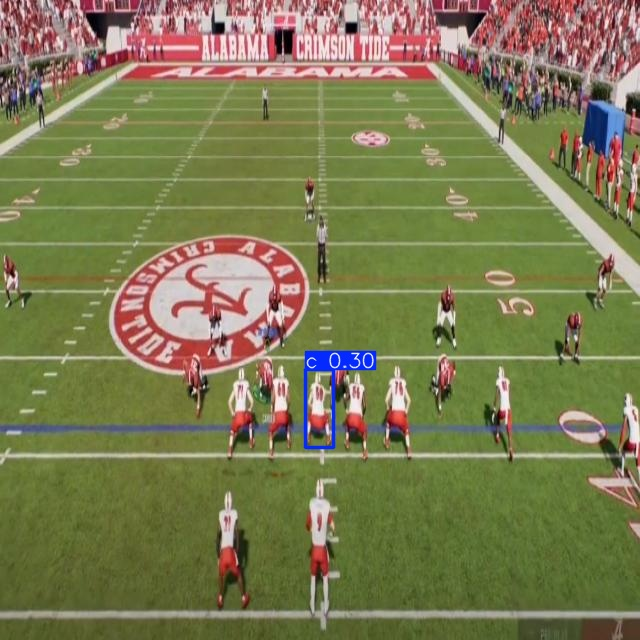

In [12]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")